In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [92]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV


In [93]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [94]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [95]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [96]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [97]:
#provides summary statistics for categorical columns

train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [98]:
#as_index=True, means new indexes will be as the index of the resulting DataFrame
#=False, will be retained as regular columns

train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [99]:
train_df.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [100]:
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [101]:
# 1 is the person on the taitaic
train_df['Family_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_size'] = train_df['SibSp'] + train_df['Parch'] + 1

In [102]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2


In [103]:
train_df.groupby(['Family_size'], as_index=False)['Survived'].mean()

,Family_size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [104]:
family_map = {1:'Alone', 2:'Small', 3:'Small', 4:'Small', 5:'Medium', 6:'Medium', 7:'Large', 8:'Large'}
train_df['Family_size_grouped'] = train_df['Family_size'].map(family_map)
test_df['Family_size_grouped'] = test_df['Family_size'].map(family_map)

In [105]:
train_df.groupby(['Family_size_grouped'], as_index=False)['Survived'].mean()

,Family_size_grouped,Survived
0,Alone,0.303538
1,Large,0.222222
2,Medium,0.162162
3,Small,0.578767


In [106]:
train_df.groupby(['Embarked'], as_index=False)['Survived'].mean() 

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


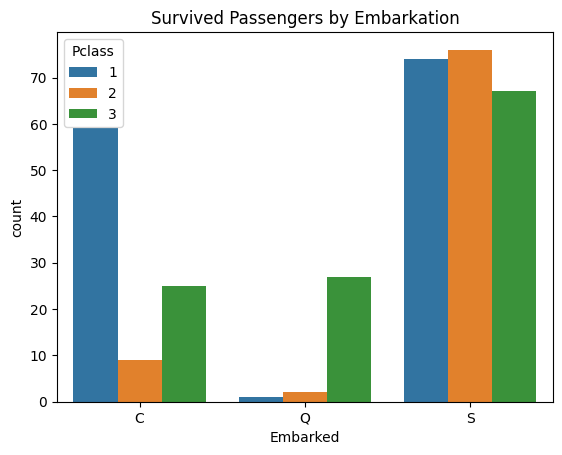

([Text(0.5, 1.0, 'Survived Passengers by Embarkation')], None)

In [107]:
sns.barplot(data=train_df[train_df['Survived'] == 1].groupby(['Embarked', 'Pclass']).size().reset_index(name='count'), x='Embarked', y='count', hue='Pclass').set(title='Survived Passengers by Embarkation'), plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

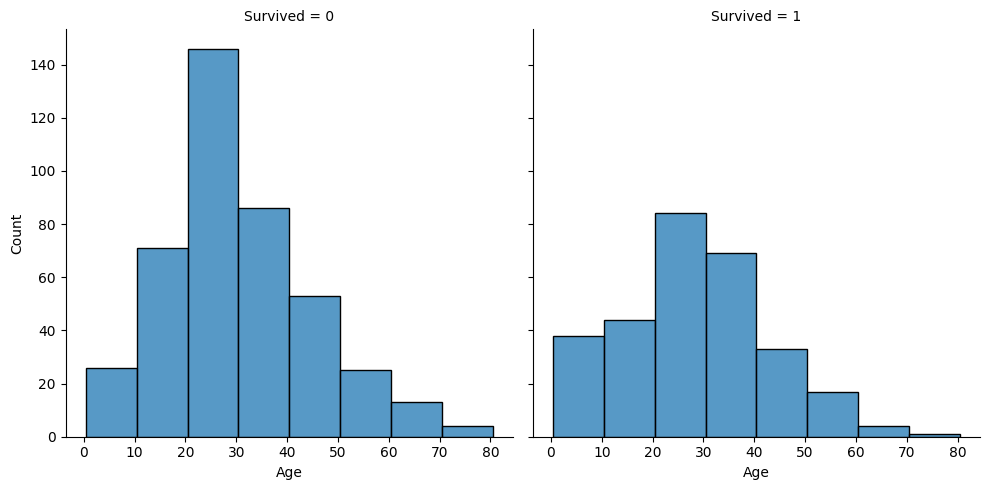

In [110]:
sns.displot(train_df, x='Age', col='Survived', binwidth=10, height=5)

In [109]:
train_df['Age_Cut'] = pd.qcut(train_df['Age'], 8)
test_df['Age_Cut'] = pd.qcut(test_df['Age'], 8)

In [111]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Family_size_grouped,Age_Cut
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(20.125, 24.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Small,"(32.312, 38.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(24.0, 28.0]"


In [112]:
train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean() 

/tmp/ipykernel_30/1648739051.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean()


,Age_Cut,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730


In [113]:
train_df.loc[train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 20.125), 'Age'] = 1
train_df.loc[(train_df['Age'] > 20.125) & (train_df['Age'] <= 24), 'Age'] = 2
train_df.loc[(train_df['Age'] > 24) & (train_df['Age'] <= 28), 'Age'] = 3
train_df.loc[(train_df['Age'] > 28) & (train_df['Age'] <= 32.312), 'Age'] = 4
train_df.loc[(train_df['Age'] > 32.312) & (train_df['Age'] <= 38), 'Age'] = 5
train_df.loc[(train_df['Age'] > 38) & (train_df['Age'] <= 47), 'Age'] = 6
train_df.loc[(train_df['Age'] > 47) & (train_df['Age'] <= 80), 'Age'] = 7
train_df.loc[train_df['Age']> 80, 'Age']

test_df.loc[test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 20.125), 'Age'] = 1
test_df.loc[(test_df['Age'] > 20.125) & (test_df['Age'] <= 24), 'Age'] = 2
test_df.loc[(test_df['Age'] > 24) & (test_df['Age'] <= 28), 'Age'] = 3
test_df.loc[(test_df['Age'] > 28) & (test_df['Age'] <= 32.312), 'Age'] = 4
test_df.loc[(test_df['Age'] > 32.312) & (test_df['Age'] <= 38), 'Age'] = 5
test_df.loc[(test_df['Age'] > 38) & (test_df['Age'] <= 47), 'Age'] = 6
test_df.loc[(test_df['Age'] > 47) & (test_df['Age'] <= 80), 'Age'] = 7
test_df.loc[test_df['Age']> 80, 'Age']

Series([], Name: Age, dtype: float64)

In [114]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Family_size_grouped,Age_Cut
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(20.125, 24.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,71.2833,C85,C,2,Small,"(32.312, 38.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(24.0, 28.0]"


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

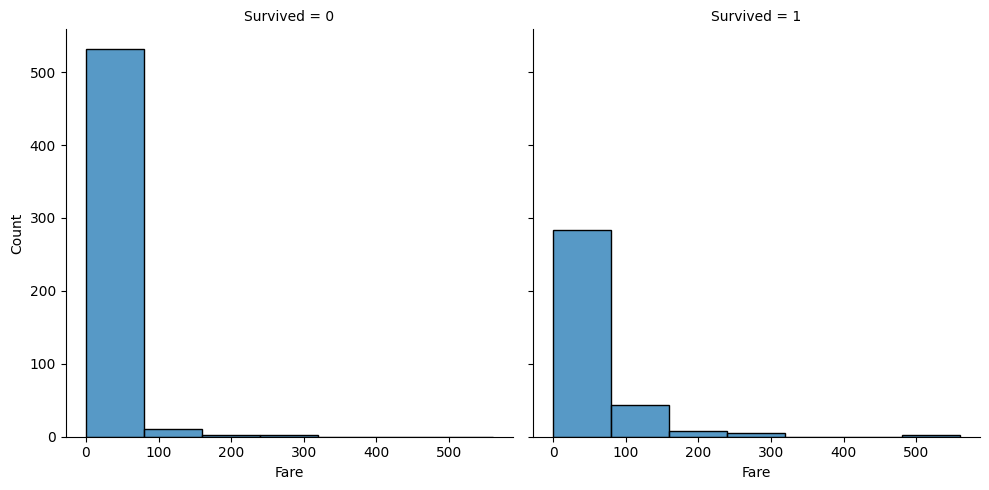

In [115]:
sns.displot(train_df, x='Fare', col='Survived', binwidth=80, height=5)

In [116]:
#given series of data into equal-sized bins based on percentiles
train_df['Fare_cut'] = pd.qcut(train_df['Fare'], 6)
test_df['Fare_cut'] = pd.qcut(test_df['Fare'], 6)

In [117]:
train_df.groupby(['Fare_cut'], as_index=False)['Survived'].mean() 

/tmp/ipykernel_30/750396125.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Fare_cut'], as_index=False)['Survived'].mean()


,Fare_cut,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [118]:
train_df.loc[train_df['Fare'] <= 7.775, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.775) & (train_df['Fare'] <= 8.662), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 8.662) & (train_df['Fare'] <= 14.454), 'Fare'] = 2
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 26.0), 'Fare'] = 3
train_df.loc[(train_df['Fare'] > 26.0) & (train_df['Fare'] <= 52.369), 'Fare'] = 4
train_df.loc[(train_df['Fare'] > 52.369) & (train_df['Fare'] <= 512.329), 'Fare'] = 5
train_df.loc[(train_df['Fare'] > 512.329), 'Fare']


test_df.loc[test_df['Fare'] <= 7.775, 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 7.775) & (test_df['Fare'] <= 8.662), 'Fare'] = 1
test_df.loc[(test_df['Fare'] > 8.662) & (test_df['Fare'] <= 14.454), 'Fare'] = 2
test_df.loc[(test_df['Fare'] > 14.454) & (test_df['Fare'] <= 26.0), 'Fare'] = 3
test_df.loc[(test_df['Fare'] > 26.0) & (test_df['Fare'] <= 52.369), 'Fare'] = 4
test_df.loc[(test_df['Fare'] > 52.369) & (test_df['Fare'] <= 512.329), 'Fare'] = 5
test_df.loc[(test_df['Fare'] > 512.329), 'Fare']

343    512.3292
Name: Fare, dtype: float64

In [119]:
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [120]:
#expand=True, the result is a new DataFrame where each split part of the original string has its own column
train_df['Name'].str.split(pat= ',', expand=True)

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry
...,...,...
886,Montvila,Rev. Juozas
887,Graham,Miss. Margaret Edith
888,Johnston,"Miss. Catherine Helen ""Carrie"""
889,Behr,Mr. Karl Howell


In [121]:
train_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Family_size_grouped,Age_Cut,Fare_cut
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,NaN,S,2,Small,"(20.125, 24.0]","(-0.001, 7.775]"


In [122]:
train_df['Name'].str.split(pat= ',', expand=True)[1]

0                                  Mr. Owen Harris
1       Mrs. John Bradley (Florence Briggs Thayer)
2                                      Miss. Laina
3               Mrs. Jacques Heath (Lily May Peel)
4                                Mr. William Henry
                          ...                     
886                                    Rev. Juozas
887                           Miss. Margaret Edith
888                 Miss. Catherine Helen "Carrie"
889                                Mr. Karl Howell
890                                    Mr. Patrick
Name: 1, Length: 891, dtype: object

In [123]:
train_df['Name'].str.split(pat= ',', expand=True)[1].str.split(pat= '.', expand=True)

,0,1,2
0,Mr,Owen Harris,None
1,Mrs,John Bradley (Florence Briggs Thayer),None
2,Miss,Laina,None
3,Mrs,Jacques Heath (Lily May Peel),None
4,Mr,William Henry,None
...,...,...,...
886,Rev,Juozas,None
887,Miss,Margaret Edith,None
888,Miss,"Catherine Helen ""Carrie""",None
889,Mr,Karl Howell,None


In [124]:
#strip() removes leading and trailing whitespace from each string element
train_df['Name'].str.split(pat= ',', expand=True)[1].str.split(pat= '.', expand=True)[0]

0         Mr
1        Mrs
2       Miss
3        Mrs
4         Mr
       ...  
886      Rev
887     Miss
888     Miss
889       Mr
890       Mr
Name: 0, Length: 891, dtype: object

In [125]:
train_df['Title'] = train_df['Name'].str.split(pat= ',', expand=True)[1].str.split(pat= '.', expand=True)[0].apply(lambda x:x.strip())
test_df['Title'] = test_df['Name'].str.split(pat= ',', expand=True)[1].str.split(pat= '.', expand=True)[0].apply(lambda x:x.strip())

In [126]:
train_df.groupby(['Title'], as_index=False)['Survived'].mean() 

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


In [127]:
train_df['Title'] = train_df['Title'].replace({
    'Capt': 'Military',
    'Col' : 'Military',
    'Major': 'Military',
    'Jonkheer': 'Nobel',
    'Lady': 'Nobel',
    'the Countess': 'Nobel',
    'Don': 'Nobel',
    'Sir': 'Nobel',
    'Mlle': 'Nobel',
    'Ms': 'Nobel',
    'Mme': 'Nobel'
})

test_df['Title'] = train_df['Title'].replace({
    'Capt': 'Military',
    'Col' : 'Military',
    'Major': 'Military',
    'Jonkheer': 'Nobel',
    'Lady': 'Nobel',
    'the Countess': 'Nobel',
    'Don': 'Nobel',
    'Sir': 'Nobel',
    'Mlle': 'Nobel',
    'Ms': 'Nobel',
    'Mme': 'Nobel' 
})

In [128]:
train_df.groupby(['Title'], as_index=False)['Survived'].agg(['count', 'mean']) 
#rev is religious

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Nobel,9,0.777778
7,Rev,6,0.000000


In [129]:
train_df['Name_length'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_length'] = test_df['Name'].apply(lambda x: len(x))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


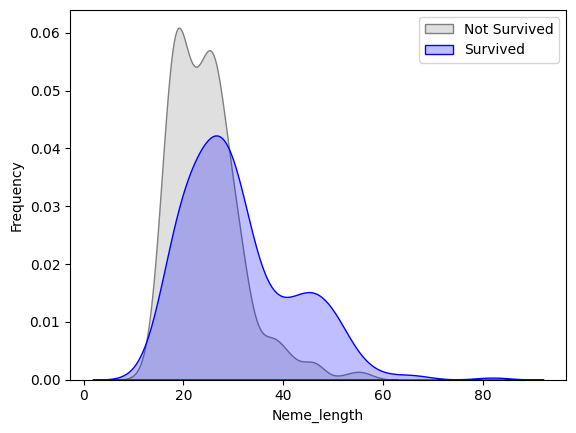

In [130]:
g = sns.kdeplot(train_df['Name_length'][(train_df['Survived']==0) & (train_df['Name_length'].notnull())], color= 'Gray', fill=True)
g = sns.kdeplot(train_df['Name_length'][(train_df['Survived']==1) & (train_df['Name_length'].notnull())], ax=g, color= 'Blue', fill=True)
g.set_xlabel('Neme_length')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [131]:
#qcut to categorize the Neme_length values into quantiles
train_df['Name_lengthgb'] = pd.qcut(train_df['Name_length'], 8)
test_df['Name_lengthgb'] = pd.qcut(test_df['Name_length'], 8)

In [132]:
train_df.groupby(['Name_lengthgb'], as_index=False)['Survived'].mean()

/tmp/ipykernel_30/3395215765.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Name_lengthgb'], as_index=False)['Survived'].mean()


,Name_lengthgb,Survived
0,"(11.999, 18.0]",0.214286
1,"(18.0, 20.0]",0.252427
2,"(20.0, 23.0]",0.307692
3,"(23.0, 25.0]",0.346939
4,"(25.0, 27.25]",0.292929
5,"(27.25, 30.0]",0.428571
6,"(30.0, 38.0]",0.517241
7,"(38.0, 82.0]",0.745283


In [133]:
train_df.loc[train_df['Name_length'] <= 18, 'Name_size'] = 0
train_df.loc[(train_df['Name_length'] > 18) & (train_df['Name_length'] <= 20), 'Name_size'] = 1
train_df.loc[(train_df['Name_length'] > 20) & (train_df['Name_length'] <= 23), 'Name_size'] = 2
train_df.loc[(train_df['Name_length'] > 23) & (train_df['Name_length'] <= 25), 'Name_size'] = 3
train_df.loc[(train_df['Name_length'] > 25) & (train_df['Name_length'] <= 27.25), 'Name_size'] = 4
train_df.loc[(train_df['Name_length'] > 27.25) & (train_df['Name_length'] <= 30), 'Name_size'] = 5
train_df.loc[(train_df['Name_length'] > 30) & (train_df['Name_length'] <= 38), 'Name_size'] = 6
train_df.loc[(train_df['Name_length'] > 38) & (train_df['Name_length'] <= 82), 'Name_size'] = 7
train_df.loc[(train_df['Name_length'] > 82), 'Name_size']


test_df.loc[test_df['Name_length'] <= 18, 'Name_size'] = 0
test_df.loc[(test_df['Name_length'] > 18) & (test_df['Name_length'] <= 20), 'Name_size'] = 1
test_df.loc[(test_df['Name_length'] > 20) & (test_df['Name_length'] <= 23), 'Name_size'] = 2
test_df.loc[(test_df['Name_length'] > 23) & (test_df['Name_length'] <= 25), 'Name_size'] = 3
test_df.loc[(test_df['Name_length'] > 25) & (test_df['Name_length'] <= 27.25), 'Name_size'] = 4
test_df.loc[(test_df['Name_length'] > 27.25) & (test_df['Name_length'] <= 30), 'Name_size'] = 5
test_df.loc[(test_df['Name_length'] > 30) & (test_df['Name_length'] <= 38), 'Name_size'] = 6
test_df.loc[(test_df['Name_length'] > 38) & (test_df['Name_length'] <= 82), 'Name_size'] = 7
test_df.loc[(test_df['Name_length'] > 82), 'Name_size']

Series([], Name: Name_size, dtype: float64)

In [134]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Family_size_grouped,Age_Cut,Fare_cut,Title,Name_length,Name_lengthgb,Name_size
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,NaN,S,2,Small,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(20.0, 23.0]",2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,5.0,C85,C,2,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(38.0, 82.0]",7.0


In [135]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [136]:
train_df['Ticket_number'] = train_df['Ticket'].apply(lambda x: pd.Series({'Ticket':  x.split()[-1]}))
test_df['Ticket_number'] = test_df['Ticket'].apply(lambda x: pd.Series({'Ticket':  x.split()[-1]}))

In [137]:
train_df.groupby(['Ticket_number'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,Ticket_number,count,mean
464,347082,7,0.000000
196,2343,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
271,2662,1,0.000000
272,2663,1,1.000000
273,2664,1,0.000000
276,2667,1,1.000000


In [138]:
train_df.groupby('Ticket_number')['Ticket_number'].transform('count')

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Ticket_number, Length: 891, dtype: int64

In [139]:
train_df['TicketNumberCounts'] = train_df.groupby('Ticket_number')['Ticket_number'].transform('count')
test_df['TicketNumberCounts'] = test_df.groupby('Ticket_number')['Ticket_number'].transform('count')

In [140]:
train_df.groupby(['TicketNumberCounts'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumberCounts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


In [141]:
train_df['Ticket'].str.split(pat=' ', expand=True)

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [142]:
train_df['TicketLocation'] = np.where(train_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), train_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')
test_df['TicketLocation'] = np.where(test_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), test_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')

In [143]:
train_df['TicketLocation'].value_counts()

TicketLocation
Blank         665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: count, dtype: int64

In [144]:
train_df['TicketLocation'] = train_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

test_df['TicketLocation'] = test_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

In [145]:
train_df.groupby(['TicketLocation'], as_index=False)['Survived'].agg(['count', 'mean'])

,TicketLocation,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


In [146]:
train_df['Cabin'] = train_df['Cabin'].fillna('U')
train_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else x for i in train_df['Cabin']])

test_df['Cabin'] = test_df['Cabin'].fillna('U')
test_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else x for i in train_df['Cabin']])

In [147]:
train_df.groupby(['Cabin'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


In [148]:
train_df['CabinAssigned'] = train_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test_df['CabinAssigned'] = test_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [149]:
train_df.groupby(['CabinAssigned'], as_index=False)['Survived'].agg(['count', 'mean'])

,CabinAssigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [150]:
train_df.shape

(891, 24)

In [151]:
test_df.shape

(418, 23)

Initializing pipeline

In [152]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  714 non-null    float64 
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    float64 
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  Family_size          891 non-null    int64   
 13  Family_size_grouped  884 non-null    object  
 14  Age_Cut              714 non-null    category
 15  Fare_cut             89

In [153]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_size',
       'Family_size_grouped', 'Age_Cut', 'Fare_cut', 'Title', 'Name_length',
       'Name_lengthgb', 'Name_size', 'Ticket_number', 'TicketNumberCounts',
       'TicketLocation', 'CabinAssigned'],
      dtype='object')

In [154]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    float64 
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    float64 
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  Family_size          418 non-null    int64   
 12  Family_size_grouped  414 non-null    object  
 13  Age_Cut              332 non-null    category
 14  Fare_cut             417 non-null    category
 15  Title                41

In [155]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

/tmp/ipykernel_30/623714052.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
/tmp/ipykernel_30/623714052.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [156]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())  
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())  
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())  

In [157]:
#a preprocessing ML technique to convert categorical variables into a format
#providable to ML algorithms, typically by creating binary columns for each category
ohe = OneHotEncoder(sparse_output=False)
ode = OrdinalEncoder
SI = SimpleImputer(strategy='most_frequent')

In [158]:
ode_cols = ['Family_size_grouped']
ohe_cols = ['Sex', 'Embarked']

In [159]:
X = train_df.drop(['Survived'], axis=1)
y = train_df['Survived']
X_test = test_df.drop(['Age_Cut', 'Fare_cut'], axis=1)

In [160]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify = y, random_state=21)

In [161]:
ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [162]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [163]:
col_trans = ColumnTransformer(transformers=[
    ('impute', SI, ['Age']),
    ('ord_pipeline', ordinal_pipeline, ode_cols),
    ('ohe_pipeline', ohe_pipeline, ohe_cols),
    ('passthrough', 'passthrough', ['Pclass', 'TicketNumberCounts', 'CabinAssigned', 'Name_size', 'Age', 'Fare'])
    ],
    remainder='drop',
    n_jobs=-1)

In [164]:
rfc = RandomForestClassifier()

In [165]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_split': [5, 10, 15],
    'max_depth': [8, 9, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

In [166]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [167]:
pipefinalrfc = make_pipeline(col_trans, CV_rfc)
pipefinalrfc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                   'TicketNumberCounts',
                                                   'CabinAssigned', 'Name_size',
                                                   'Age', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [8, 9, 10, 15, 20],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15],
                                          'n_estimators': [100, 150, 200]}))])

In [168]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.8272530286614794


In [169]:
dtc = DecisionTreeClassifier()

In [172]:
param_grid = {
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

In [173]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [174]:
pipefinaldtc = make_pipeline(col_trans, CV_dtc)
pipefinaldtc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass',
                                                   'TicketNumberCounts',
                                                   'CabinAssigned', 'Name_size',
                                                   'Age', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 20, 30],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15]}))])

In [175]:
print(CV_dtc.best_params_)
print(CV_dtc.best_score_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 15}
0.8131685216192258


In [179]:
knn = KNeighborsClassifier()

In [181]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
}

In [182]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [183]:
pipefinalknn = make_pipeline(col_trans, CV_knn)
pipefinalknn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass',
                                                   'TicketNumberCounts',
                                                   'CabinAssigned', 'Name_size',
                                                   'Age', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'kd_tree', 'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'p': [1, 2],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [184]:
print(CV_knn.best_params_)
print(CV_knn.best_score_)

{'algorithm': 'brute', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
0.8033881611346401


In [185]:
svc = SVC()

In [186]:
param_grid = {
    'C':[100, 10, 1.0, 0.1, 0.001, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

In [187]:
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [188]:
pipefinalsvc = make_pipeline(col_trans, CV_svc)
pipefinalsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass',
                                                   'TicketNumberCounts',
                                                   'CabinAssigned', 'Name_size',
                                                   'Age', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001],
                                          'kernel': ['linear', 'poly', 'rbf',
                                                     'sigmoid']}))])

In [189]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'C': 10, 'kernel': 'rbf'}
0.7991529597163399


In [190]:
lr = LogisticRegression()

In [192]:
param_grid = {
    'C':[100, 10, 1.0, 0.1, 0.001, 0.001],
}

In [194]:
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [195]:
pipefinallr = make_pipeline(col_trans, CV_lr)
pipefinallr.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass',
                                                   'TicketNumberCounts',
                                                   'CabinAssigned', 'Name_size',
                                                   'Age', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001]}))])

In [197]:
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'C': 0.1}
0.8048163104501134


In [198]:
gnb = GaussianNB()

In [200]:
param_grid = {
    'var_smoothing': [0.0000001, 0.000000001, 0.00000001]
}

In [207]:
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [211]:
pipefinalgnb = make_pipeline(col_trans, CV_gnb)
pipefinalgnb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass',
                                                   'TicketNumberCounts',
                                                   'CabinAssigned', 'Name_size',
                                                   'Age', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GaussianNB(),
                              param_grid={'var_smoothing': [1e-07, 1e-09,
                                                            1e-08]}))])

In [212]:
print(CV_gnb.best_params_)
print(CV_gnb.best_score_)

{'var_smoothing': 1e-07}
0.7781049935979514


In [215]:
Y_pred = pipefinalrfc.predict(X_test)
Y_pred2 = pipefinaldtc.predict(X_test)
Y_pred3= pipefinalknn.predict(X_test)
Y_pred4 = pipefinalsvc.predict(X_test)
Y_pred5 = pipefinallr.predict(X_test)
Y_pred6 = pipefinalgnb.predict(X_test)

In [217]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred
    })

submission2 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred2
    })

submission3 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred3
    })

submission4 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred4
    })

submission5 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred5
    })

submission6 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred6
    })

In [218]:
submission.to_csv('/kaggle/working/submission1912_1.csv', index=False)
submission.to_csv('/kaggle/working/submission1912_2.csv', index=False)
submission.to_csv('/kaggle/working/submission1912_3.csv', index=False)
submission.to_csv('/kaggle/working/submission1912_4.csv', index=False)
submission.to_csv('/kaggle/working/submission1912_5.csv', index=False)
submission.to_csv('/kaggle/working/submission1912_6.csv', index=False)
